# Using Jupyter widgets to explore simple queueing models in Python

I use Jupyter notebooks extensively in my teaching and research. For a while now, I've been wanting to explore the use of [Jupyter Widgets (ipywidgets](http://ipywidgets.readthedocs.io/en/latest/index.html) to add interactivity to notebooks and also as a kind of lightweight GUI for analytical applications. Some of my research involves [queueing models](https://en.wikipedia.org/wiki/Queueing_theory) and I've coded up a bunch of Python functions for computing various performance measures a number of common queueing systems. We'll use a few of those functions to start to learn to use `ipywidgets`. The two basic queueing models we'll explore are the $M/M/c$ and $M/G/c/c$ queueing systems ([Kendall's notation is shorthand for describing such systems](https://en.wikipedia.org/wiki/Kendall%27s_notation)). Both of these models (and their numerous variants) have been used extensively in customer service systems such as call centers and hospitals.

**$M/M/c$ - multiserver Markovian queue**

- Poisson arrivals (exponentially distributed interarrival times)
- exponential service
- c servers
- unlimited queue size
- arrivals finding all servers busy join the FCFS queue to wait for an available server

**$M/G/c/c$ - Erlang loss system**

- Poisson arrivals (exponentially distributed interarrival times)
- general service time distribution
- c servers
- no queueing allowed (the second c in $M/G/c/c$ is the total number of customers allowed in system (service + queue)
- arrivals finding all servers busy are lost to the system

## Preliminaries
Do some magic and import some libraries.

In [3]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

Here are the imports needed for the widgets.

In [1]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display

## Functions to compute performance measures

Here are the two functions we'll use for this first part. The `erlangb()` function computes the probability that an arrival to an $M/G/c/c$ system finds the system full and is lost. The `erlangc()` function computes the probability that an arrival to an $M/M/c$ system finds the system full and has to wait in queue for an available server. Both the [Erlang-B](https://en.wikipedia.org/wiki/Erlang_%28unit%29#Erlang_B_formula) and [Erlang-C](https://en.wikipedia.org/wiki/Erlang_%28unit%29#Erlang_C_formula) are well known queueing formulas and have efficient computational implementations.


In [4]:
def erlangb(load, c):
    """
    Return the the probability of loss in M/G/c/c system using recursive approach.

    Much faster than direct computation via
    scipy.stats.poisson.pmf(c, load) / scipy.stats.poisson.cdf(c, load)

    Parameters
    ----------
    load : float
        average arrival rate * average service time (units are erlangs)
    c : int
        number of servers

    Returns
    -------
    float
        probability arrival finds system full

    """

    invb = 1.0
    for j in range(1, c + 1):
        invb = 1.0 + invb * j / load

    b = 1.0 / invb

    return b


Here's a quick plot of the Erlang-B function for an $M/G/1/1$ system and a range of traffic intensities. A few things to note:

- Usually we represent the arrival rate by the greek letter $\lambda$. It's the average number of customer arrivals per unit time.
- Each server can process arrivals at a rate $\mu$. So, $\frac{1}{\mu}$ is the average amount of time that a customer spends in the system.
- The *traffic intensity*, usually denoted by the greek letter rho ($\rho$), is the ratio of the customer arrival rate, $\lambda$, to the system's overall service rate, $c\mu$. 
- The *load*  is $c\rho$ where $c$ is the number of servers and the units are known as *erlangs*,
- For $M/M/c$ systems to be stable and to be able to compute the Erlang-C function, we need $\rho < 1$ (traffic intensities greater than 1 are ok for $M/G/c/c$ but you'll just get more and more customers being lost).

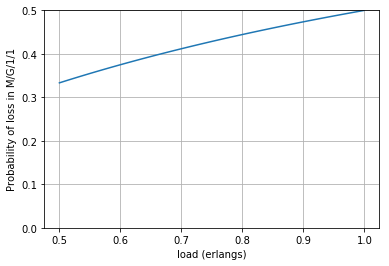

In [66]:
rho = np.linspace(0.5, .999, 50)
c = 1
plt.plot(rho, erlangb(rho*c,c))
plt.ylim(0, .5)
plt.xlabel('load (erlangs)')
plt.ylabel('Probability of loss in M/G/{}/{}'.format(c, c))
plt.grid()
plt.show()

Even for traffic intensities very close to 1.0, the probability that an arriving customer finds the system full is less than 0.5. Let's let the traffic intensity exceed 1.0 (i.e. arrivals showing up on average faster than we can serve them).

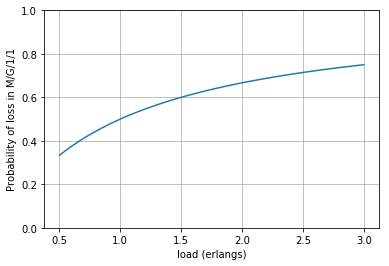

In [65]:
rho = np.linspace(0.5, 3, 50)
c = 1
plt.plot(rho, erlangb(rho*c,c))
plt.ylim(0, 1.0)
plt.xlabel('load (erlangs)')
plt.ylabel('Probability of loss in M/G/{}/{}'.format(c, c))
plt.grid()
plt.show()

## Getting started with `ipywidgets`
Go check out the [Jupyter Widgets User Guide](http://ipywidgets.readthedocs.io/en/latest/index.html) to familiarize yourself with the basics of widgets. My goal was to use widgets to allow me to control the number of servers in these two queueing systems and display both graphical and text output of the Erlang B and C formulas. This is a pretty simple use case but one that will allow me to start to understand widgets.

Let's start by creating an `IntSlider` widget that lets the user pick the number of servers. The arguments are pretty self-explanatory.

In [69]:
# Create the integer slider object
pick_c = widgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    description='Number of servers'
)

To show the slider, we can use the `display`function from the `IPython.display` module. Try it out.

In [70]:
display(pick_c)

Our goal is to somehow have such a slider interact with our queueing related functions. We want to call a function and pass in the slider value as an argument. As a simple example, consider the following function.

In [73]:
def f(x):
    print(x ** 2)

In [74]:
f(5)

25


To "hook up" the slider to the function, use the [`interact` function](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). A few things to note:

- The function is passed in as the first argument.
- The second argument to `interact` is a named argument which references the widget we want to use.
- We can pass a widget variable we've already created or create one on the fly.

In [75]:
interact(f, x=widgets.IntSlider(min=1,max=50,step=1,value=5,description='Number to square'));

Put all these ideas together and we end up with an interactive plot showing how the Erlang-B function varies across a range of traffic intensities for a given number of servers.

In [76]:
# Create function to generate plot based on erlang-b and slider controlling number of servers
def erlangb_lossplot(num_servers):
    plt.figure(1)
    rho = np.linspace(0.5, .999, 200)
    plt.plot(rho, erlangb(rho*num_servers,num_servers))
    plt.ylim(0, .5)
    plt.xlabel('load (erlangs)')
    plt.ylabel('Probability of loss in M/G/c/c')
    plt.grid()
    plt.show()

# Create a widget for the number of servers
c_1 = widgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    description='Number of servers'
)

# Create an interactive element and hook the slider to the erlang-b function
interact(erlangb_lossplot, num_servers=c_1);

Now let's do the same thing with the Erlang-C function.

In [77]:
def erlangc(load, c):
    """
    Return the the probability of delay in M/M/c/inf system using recursive Erlang B approach.


    Parameters
    ----------
    load : float
        average arrival rate * average service time (units are erlangs)
    c : int
        number of servers

    Returns
    -------
    float
        probability all servers busy

    """

    rho = load / float(c)
    #if rho.any() >= 1.0:
    #    raise ValueError("rho must be less than 1.0")
    
    eb = erlangb(load, c)
    ec = 1.0 / (rho + (1 - rho) * (1.0 / eb))

    return ec

Let's include both Erlang-B and C on this plot. Notice also that instead of `interact`, we are using `interactive`. The `interactive` function returns an interactive widget object that can then be modified or interrogated (e.g. to get the values passed in). See the [docs](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) for more details.

In [78]:
def erlangc_pwaitplot(num_servers):
    plt.figure(2)
    rho = np.linspace(0.5, .999, 50)
    plt.plot(rho, erlangc(rho*num_servers,num_servers), label='P[Wait>0] in M/M/c')
    plt.plot(rho, erlangb(rho*num_servers,num_servers), label='P[loss] in M/G/c/c')
    plt.ylim(0, 1.0)
    plt.xlabel('load (erlangs)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.show()

c_2 = widgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    description='Number of servers'
)

# Instead of interact, we'll use interactive so that we can reuse the interactive object
# and set some of its properties (height of layout area in this case).
interactive_plot_c = interactive(erlangc_pwaitplot, num_servers=c_2)
interactive_plot_c.layout.height = '350px'
interactive_plot_c

Another useful widget allows the user to select a range via a slider. Let's try it out for selecting the range of traffic intensities. Start out by creating a `FloatRangeSlider` object and then displaying it. Try it out. Note the use of LaTex in the description.

In [81]:
rho_range = widgets.FloatRangeSlider(
    value=[0.5, .99],
    min=0.01,
    max=0.99,
    step=0.01,
    description=r'Range for \(\rho \)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

In [82]:
display(rho_range)

In [87]:
# Print out the key slider property values
print(rho_range.lower, rho_range.upper)
# The value property of the slider is a tuple containing the lower and upper range choices.
print(rho_range.value)

0.19 0.58
(0.19, 0.58)


Create function that takes both widgets as inputs.

In [88]:
def erlangc_pwaitplot2(num_servers, rho_range):
    plt.figure(3)
    rho = np.linspace(rho_range[0], rho_range[1], 50)
    plt.plot(rho, erlangc(rho*num_servers,num_servers), label='Prob of wait: $P(W>0)$ in M/M/c')
    plt.plot(rho, erlangb(rho*num_servers,num_servers), label='Prob of loss: $P(N=c)$ in M/G/c/c')
    plt.ylim(0, 1.0)
    plt.xlabel('load (erlangs)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.show()

interactive_plot_rhorange = interactive(erlangc_pwaitplot2, num_servers=c_2, rho_range=rho_range)
interactive_plot_rhorange

## System Dimensioning
Finally, let's use both models for simple "dimensioning" by choosing the number of servers such that some specified *overflow threshold* on the loss probability (for $M/G/c/c$) or probability of waiting (for $M/M/c$). We'll use both `Text` widgets and a few different container widgets.

We'll use a `FloatSlider` for the overflow threshold and for the load placed on the system.

In [90]:
overflow_threshold_slider = widgets.FloatSlider(
    value=0.05,
    min=0.01,
    max=0.25,
    step=0.01,
    description='Overflow threshold'
)

load_slider = widgets.FloatSlider(
    value=5.0,
    min=0.0,
    max=50,
    step=0.5,
    description='Load'
)

Here's are two "inverse" functions that return the number of servers needed to serve a given load and meet a specified overflow probability threshold.

In [91]:
def erlangc_inv(prob, load):
    """
    Return the number of servers such that probability of delay in M/M/c/inf system is
    less than specified probability


    Parameters
    ----------
    prob : float
        threshold delay probability
    load : float
        average arrival rate * average service time (units are erlangs)

    Returns
    -------
    c : int
        number of servers

    """

    c = math.ceil(load)
    ec = erlangc(load, c)
    if ec <= prob:
        return c
    else:
        while ec > prob:
            c += 1
            ec = erlangc(load, c)

    return c

def erlangb_inv(prob, load):
    """
    Return the number of servers such that probability of loss in an M/G/c/c system is
    less than specified probability


    Parameters
    ----------
    prob : float
        threshold loss probability
    load : float
        average arrival rate * average service time (units are erlangs)

    Returns
    -------
    c : int
        number of servers

    """

    c = math.ceil(load)
    ec = erlangb(load, c)
    if ec <= prob:
        return c
    else:
        while ec > prob:
            c += 1
            ec = erlangc(load, c)

    return c

There are several different text related widgets.

In [92]:

widgets.Text(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)

We'll use `IntText` widgets for displaying integer values corresponding to the number of servers needed. Note that we are setting `disabled=True` as we won't be using these text boxes for input but simply for output display.

In [94]:
b_out = widgets.IntText(
            value=0,
            description='Servers for M/G/c/c:',
            disabled=True
        )

c_out = widgets.IntText(
            value=0,
            description='Servers for M/M/c:',
            disabled=True
        )

Before trying to get the output text boxes working, let's just test out a function for calling the inverse functions.

In [95]:
def dimensioner1(load, threshold):
        b = erlangb_inv(threshold, load)
        c = erlangc_inv(threshold, load)
        
        print(b,c)

In [96]:
interact(dimensioner1, load=load_slider, threshold=overflow_threshold_slider);


Now, instead of printing the two server values, let's set the value property of our `IntText` widgets and then display them.

In [97]:
def dimensioner2(load, threshold):
        b = erlangb_inv(threshold, load)
        c = erlangc_inv(threshold, load)
        
        b_out.value = b
        c_out.value = c
        

In [98]:
display(b_out)
display(c_out)

Now set up the interactive sliders. Try them out and watch what happens to the text boxes above.

In [99]:
interact(dimensioner2, load=load_slider, threshold=overflow_threshold_slider);

Let's enhance the output by also computing and displaying the actual loss and wait probabilities associated with the numbers of servers returned by the inverse functions.

In [100]:
b_prob_out = widgets.Text(
            value='0.0',
            description='P[loss] in M/G/c/c:',
            disabled=True
        )

c_prob_out = widgets.Text(
            value='0.0',
            description='P[wait] in M/M/c:',
            disabled=True
        )

In [101]:
def dimensioner3(load, threshold):
        b = erlangb_inv(threshold, load)
        c = erlangc_inv(threshold, load)
        
        b_prob = erlangb(load, b)
        c_prob = erlangc(load, c)
        
        b_out.value = b
        c_out.value = c
        
        b_prob_out.value = '{:.4f}'.format(b_prob)
        c_prob_out.value = '{:.4f}'.format(c_prob)        

We can use `VBox` and `HBox` widgets to create a simple rectangular layout of text boxes. Finally, we'll create the interactive widgets.

In [103]:
left_box = widgets.VBox([b_out, b_prob_out])
right_box = widgets.VBox([c_out, c_prob_out])
widgets.HBox([left_box, right_box])

In [104]:
interact(dimensioner3, load=load_slider, threshold=overflow_threshold_slider);

We've barely scratched the surface of what is possible with Jupyter widgets. Now that we have a basic understanding of how they work, I'll move on to using them to create a very lightweight interface to my [hillmaker](https://github.com/misken/hillmaker/) application.